## Exercise 7

### Introduction

In this exercise the Metropolis algorithm is applied to a Molecular Dynamics problem. The acceptance is evaluated through Lennard-jones potential. Moreover, tail correction have been added in the calculation of potential energy and pressure.

$$ \frac{V_{tail}}{N}=\frac{8}{3} \pi \rho \epsilon \sigma^3 \left[ \frac{1}{3} \left(\frac{\sigma}{r_c} \right)^9 - \left(\frac{\sigma}{r_c} \right)^3 \right] $$

$$ \frac{W_{tail}}{3\epsilon N}=\frac{16}{3} \pi \rho \epsilon \sigma^3 \left[ \frac{2}{3} \left(\frac{\sigma}{r_c} \right)^9 - \left(\frac{\sigma}{r_c} \right)^3 \right], $$

which in Lennard-Jones units ($\sigma= 1$ and $\epsilon=1$) become:

$$ \frac{V_{tail}^*}{N}=\frac{8}{3} \pi \rho^* \left[ \frac{1}{3} \left(\frac{1}{r_c^*} \right)^9 - \left(\frac{1}{r_c^*} \right)^3 \right] $$

$$ \frac{W_{tail}^*}{3 N}=\frac{16}{3} \pi \rho^* \left[ \frac{2}{3} \left(\frac{1}{r_c^*} \right)^9 - \left(\frac{1}{r_c^*} \right)^3 \right]. $$

### 7.1 Equilibration

In this exercise the optimized $\delta$ value (i.e. the step length $\delta$ so that the acceptance is approximately 90%) is already set in the input file:
- $\delta = 7.5$ for gas
- $\delta = 0.2$ for liquid
- $\delta = 0.12$ for solid

So in this first part of the exercise the focus is on the optimization of the block length for the data-blocking method (applied later in 7.2). This was worked out observing the trend of a specific function of the quantities of interest, called the autocorrelation fuction.

#### 7.1.0 Equilibrated instant values

At the very beginning graphs of potential energy and pressure were produced to estimate the minimum number of necessary steps for the equilibration.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

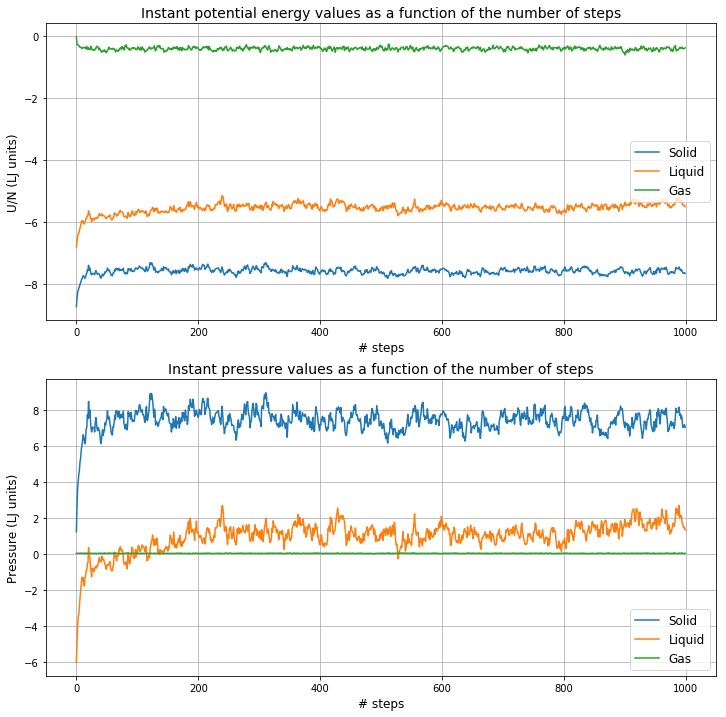

In [4]:
##Potential energy and pressure with 1000 steps
M=1000
step = np.arange(M)
press_solid = np.loadtxt( './Solid/instant_prova1.dat',max_rows=M ,usecols=1)
epot_solid = np.loadtxt( './Solid/instant_prova1.dat' ,max_rows=M ,usecols=0)
press_liquid = np.loadtxt( './Liquid/instant_prova1.dat',max_rows=M ,usecols=1)
epot_liquid = np.loadtxt( './Liquid/instant_prova1.dat' ,max_rows=M ,usecols=0)
press_gas = np.loadtxt( './Gas/instant_prova1.dat',max_rows=M ,usecols=1)
epot_gas = np.loadtxt( './Gas/instant_prova1.dat' ,max_rows=M ,usecols=0)
press = [press_solid , press_liquid, press_gas]
epot = [epot_solid, epot_liquid, epot_gas]
phases = ["Solid", "Liquid" , "Gas"]

plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
for e in range(3):
    plt.plot ( step, epot[e], label=phases[e])
plt.xlabel('# steps',size=12)
plt.ylabel('U/N (LJ units)',size=12)
plt.title("Instant potential energy values as a function of the number of steps", size=14)
plt.legend(loc="center right", fontsize=12)
plt.grid(True)

plt.subplot(2,1,2)
for e in range(3):
    plt.plot ( step, press[e], label=phases[e])
plt.xlabel('# steps',size=12)
plt.ylabel('Pressure (LJ units)',size=12)
plt.title("Instant pressure values as a function of the number of steps", size=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

As seen in these graphs, the system's equilibration time is somewhat between 200 and 400 steps. Thus a function $Equilibration (\ )$ was added to the cpp program, which just runs the simulation 400 steps before starting to measure pressure and potential energy per particle. it is possible to notice that solid phase has a higher pressure and a stronger potential energy (higher in absolute values). In gas phase these are both about 0, while the liquid phase behaviour is somewhere in between the two.
All quantities are of order 1 (as expected using LJ units).

After that, the code was run with $5 \times 10^5$ steps: the followimg graphs report instantaneous values of potential energy per particle and pressure along equilibrated Monte Carlo simulations. 

In [7]:
#loading instant values
M=500000
press_solid = np.loadtxt( './Solid/instant_forseok.dat',max_rows=M ,usecols=1)
epot_solid = np.loadtxt( './Solid/instant_forseok.dat' ,max_rows=M ,usecols=0)
press_liquid = np.loadtxt( './Liquid/instant_forseok3.dat',max_rows=M ,usecols=1)
epot_liquid = np.loadtxt( './Liquid/instant_forseok3.dat' ,max_rows=M ,usecols=0)
press_gas = np.loadtxt( './Gas/instant_forseok4.dat',max_rows=M ,usecols=1)
epot_gas = np.loadtxt( './Gas/instant_forseok4.dat' ,max_rows=M ,usecols=0)

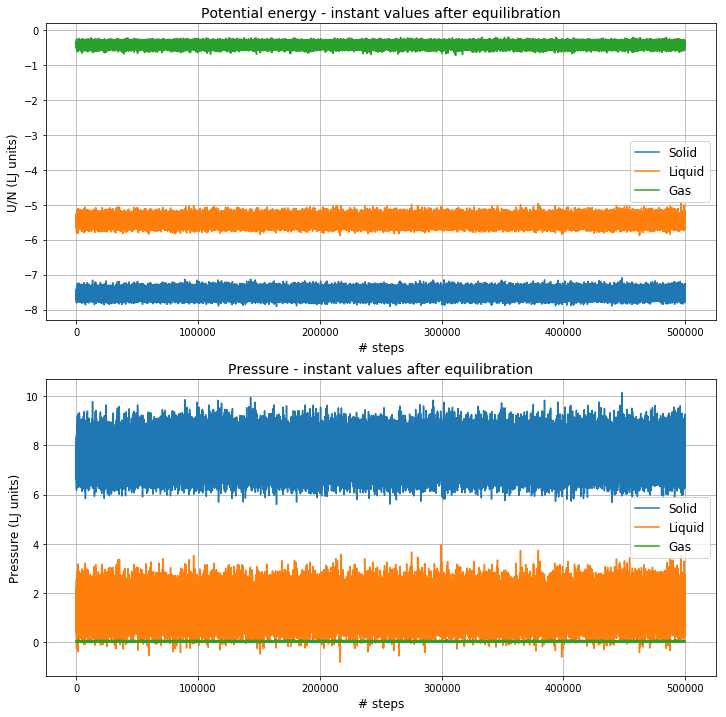

In [8]:
#Instant values of potential energy and pressure with 500000 steps after equilibration

M=500000
step = np.arange(M)
press = [press_solid , press_liquid, press_gas]
epot = [epot_solid, epot_liquid, epot_gas]
phases = ["Solid", "Liquid" , "Gas"]

plt.figure(figsize=(12,12))

plt.subplot(2,1,1)
for e in range(3):
    plt.plot ( step, epot[e], label=phases[e])
plt.xlabel('# steps',size=12)
plt.ylabel('U/N (LJ units)',size=12)
plt.title("Potential energy - instant values after equilibration", size=14)
plt.legend(loc="center right", fontsize=12)
plt.grid(True)

plt.subplot(2,1,2)
for e in range(3):
    plt.plot ( step, press[e], label=phases[e])
plt.xlabel('# steps',size=12)
plt.ylabel('Pressure (LJ units)',size=12)
plt.title("Pressure - instant values after equilibration", size=14)
plt.legend(loc="center right", fontsize=12)
plt.grid(True)

#### 7.1.1 Autocorrelation

In this section instant values were used to evaluate the autocorrelation functions for both potential energy and pressure (up to 300 values). Autocorrelation was calculated as:

$$ \chi(\delta t) = \frac{1}{\sigma_m^2} \times \Big ( \frac{1}{t_{max}- \delta t} \sum_{t' = 0}^{t_{max}- \delta t} m(t')m(t'+ \delta t) - \frac{1}{t_{max}- \delta t} \sum_{t' = 0}^{t_{max}- \delta t} m(t') \frac{1}{t_{max}- \delta t} \sum_{t' = 0}^{t_{max}- \delta t} m(t' + \delta t) \Big ) $$

where $m$ is respectively potential energy and pressure, $\delta t \in [0; 300]$ steps.

In [9]:
## autocorrelation with python script
from scipy.optimize import curve_fit
##funzione che dato un numero di step resituisce un vettore con l'autocorrelazione per quegli step
## m = vettore con tutti i valori della quantità di cui calcolare la chi
def autocorrelation(m, nstep):
    t_max =len(m) ## numero di totale di valori di m
    chi=np.zeros(nstep)
    devst = np.std(m)
    
    for deltat in range(nstep):
        sum1=0.
        sum2=0.
        sum3=0.
        for t in range(t_max-deltat):
            sum1 += m[t]*m[t + deltat]
            sum2 += m[t]
            sum3 += m[t + deltat]
        chi[deltat] =(sum1/(t_max-deltat) - sum2*sum3/(t_max-deltat)/(t_max-deltat))/devst/devst
        
    return chi
    
## fitting function
def fit_function(t, t_c):
    return np.exp(-t/t_c)

Potential energy Solid: t_c value from fitting  8.164711411794922
Pressure Solid: t_c value from fitting  8.03461953421275
Potential energy Liquid: t_c value from fitting  9.681015409673623
Pressure Liquid: t_c value from fitting  12.476681151212976
Potential energy Gas: t_c value from fitting  2.2689345408684387
Pressure Gas: t_c value from fitting  0.8686434301300662


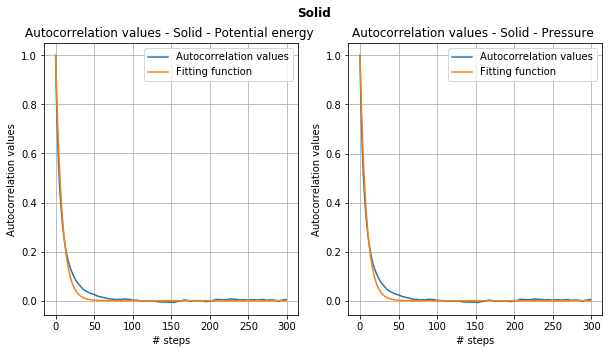

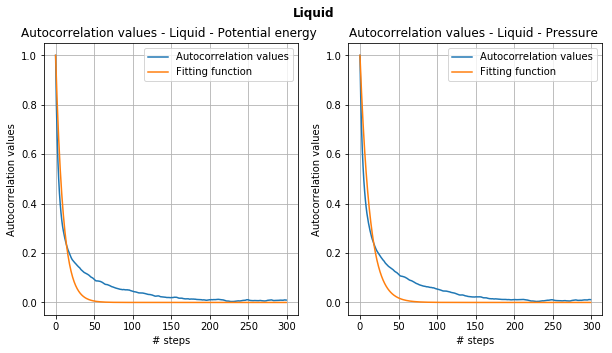

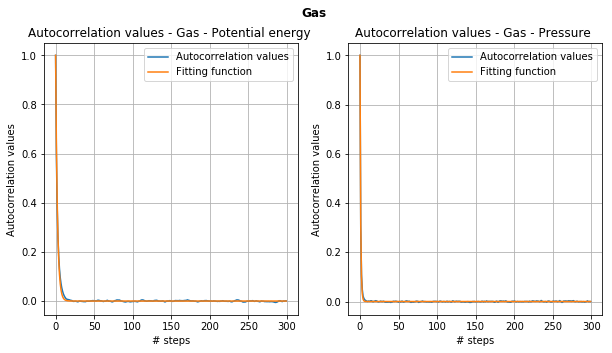

In [12]:
##fit & plot - energy & pressure - solid
nstep = 300
t_max=50000
xdata = np.arange(nstep)
phases = ["Solid" ,"Liquid", "Gas"]
for p in range(3):
    plt.figure(figsize=(10,5))
    plt.suptitle(phases[p], weight="bold")
    titles = ["Potential energy " , "Pressure "]
    for i in range(2):
        #fitting
        if(i == 0):
            data = epot[p]
        else:
            data = press[p]
        ##prima colonna e_pot, seconda pressione
        chi_vals = autocorrelation(data, nstep)
        popt, pcov = curve_fit(fit_function, xdata, chi_vals)
        print( titles[i] + phases[p] + ": t_c value from fitting ", popt[0])

        #plotting
        plt.subplot(1, 2 ,i+1)
        plt.plot(xdata, chi_vals, label="Autocorrelation values")
        plt.plot(xdata, fit_function(xdata, popt[0]), label="Fitting function")
        plt.xlabel("# steps")
        plt.ylabel("Autocorrelation values")
        plt.title("Autocorrelation values - " + phases[p]+ " - " + titles[i])
        plt.legend(loc="upper right")
        plt.grid(True)

The block length should be at least $2 t_c$:
- potential energy, solid: $L \geq 16$
- pressure solid: $L \geq 16$
- potential energy liquid: $L \geq 20$
- pressure liquid: $L \geq 25$
- potential energy gas:  $L \geq 5$
- pressure gas: $L \geq 2$

#### 7.1.2 Errors

The following graphs report the trend of the final error of the final average value calculated through the data-blocking method VS different block lengths $L$ from $L=10$ to $L=5\times 10^3$.

In [13]:
## errors with python script (M = total number of steps, N=# blocks, L = block length)
###PROVA 2
def Error(mean, mean2, n):
    if(n==0):
        return 0
    else:
        return np.sqrt((mean2 - mean*mean)/n)
    
def err_blocks(x, M, N):
    L = int(M/N) ##lunghezza blocco
    meantot =0.
    meantot2 =0.
    for n in range(N):
        mean_block = 0.
        for l in range(int(L)):
            mean_block += x[n*L + l]
        mean_block /= L 
        meantot = (meantot*n + mean_block)/float(n+1)
        meantot2 = (meantot2*n + mean_block*mean_block)/float(n+1)
    error = Error(meantot, meantot2, N-1) ## mi interessa solo quello finale
    return meantot, error

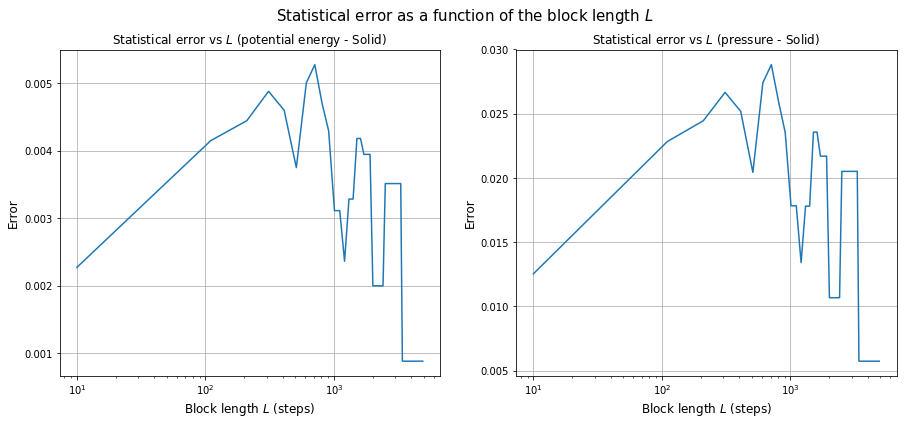

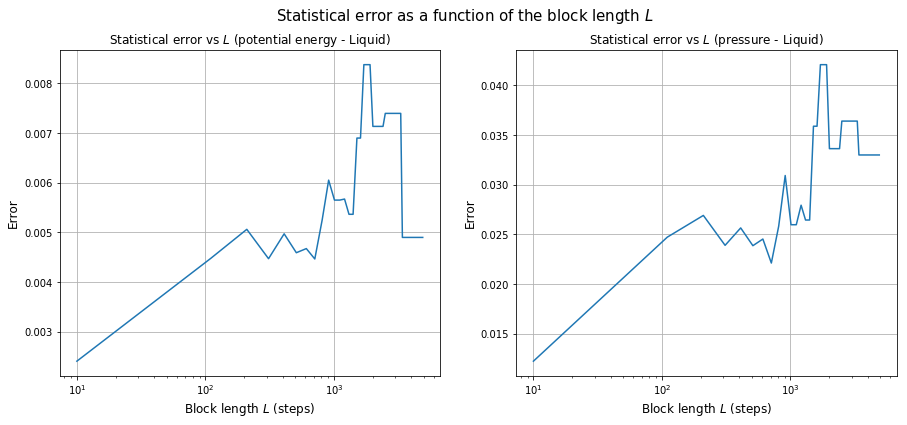

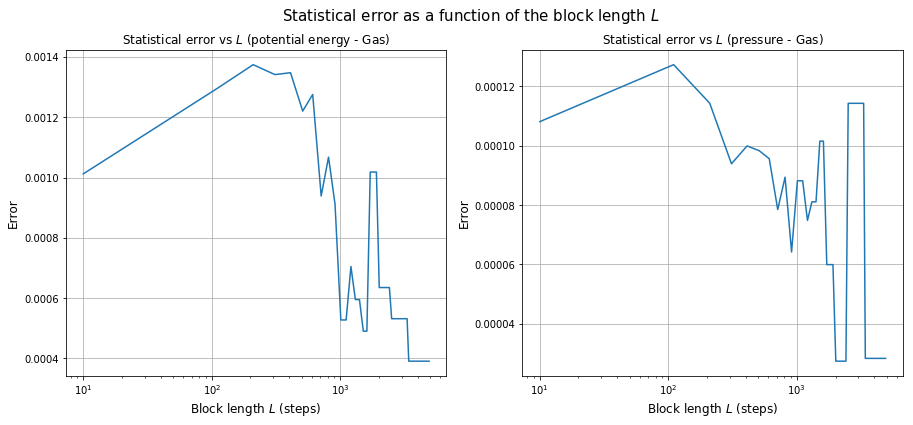

In [20]:
phases = ["Solid", "Liquid", "Gas"]
for p, energy, pressure in (phases, epot, press):
    L_step = 100
    L_values = np.arange(10, 5000, L_step)  ## l'ultimo è lo step non quanti ce ne sono
    err_epot = []
    err_press = []
    M = len(energy)

    for l in L_values:
        N = int(M/l)
        err_epot.append(err_blocks(energy, M, N)[1])
        err_press.append(err_blocks(pressure, M, N)[1])

    plt.figure(figsize=(15,6))
    plt.suptitle("Statistical error as a function of the block length $L$", size=15)

    plt.subplot(1,2,1)
    plt.plot(L_values, err_epot)
    plt.xlabel("Block length $L$ (steps)", size=12)
    plt.ylabel("Error", size=12)
    plt.title("Statistical error vs $L$ (potential energy - " + p + ")",  size=12)
    plt.xscale("log")
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(L_values, err_press)
    plt.xlabel("Block length $L$ (steps)", size=12)
    plt.ylabel("Error", size=12)
    plt.title("Statistical error vs $L$ (pressure - " + p + ")", size=12)
    plt.xscale("log")
    plt.grid(True)

It is possible to work out the minimum block length so that the error reaches a maximum:
- solid phase: $\approx$ 300 steps
- liquid phase: $\approx$ 200 steps
- gas phase: $\approx$ 200 steps

### 7.2 radial distribution function $g(r)$ in the Monte Carlo NVT code

In this part of the exercise the calculation of $g(r)$ was added to the code. This function represents the probability of finding two particles at a distance *r* apart, on the same probability in a totally random system at the same density. The following graphs report the final average values of g(r) for $r \in \left[ 0; L/2\right]$.

In [ ]:
## loading values

## g(r)
g_solid = np.loadtxt("./Solid/output_gaveforseok.dat", max_rows=M, usecols=3)
g_err_solid = np.loadtxt("./Solid/output_gaveforseok.dat", max_rows=M, usecols=4)
r_vals_solid = np.loadtxt("./Solid/output_gaveforseok.dat", max_rows=M, usecols=1)
g_liquid = np.loadtxt("./Liquid/output_gaveforseok3.dat", max_rows=M, usecols=3)
g_err_liquid = np.loadtxt("./Solid/output_gaveforseok3.dat", max_rows=M, usecols=4)
r_vals_liquid = np.loadtxt("./Solid/output_gaveforseok3.dat", max_rows=M, usecols=1)
g_gas = np.loadtxt("./Gas/output_gaveforseok4.dat", max_rows=M, usecols=3)
g_err_gas = np.loadtxt("./Gas/output_gaveforseok4.dat", max_rows=M, usecols=4)
r_vals_gas = np.loadtxt("./Gas/output_gaveforseok4.dat", max_rows=M, usecols=1)

g_values = [g_solid, g_liquid, g_gas]
g_errs = [g_err_solid, g_err_liquid, g_err_gas]
r_values = [r_vals_solid, r_vals_liquid, r_vals_gas]

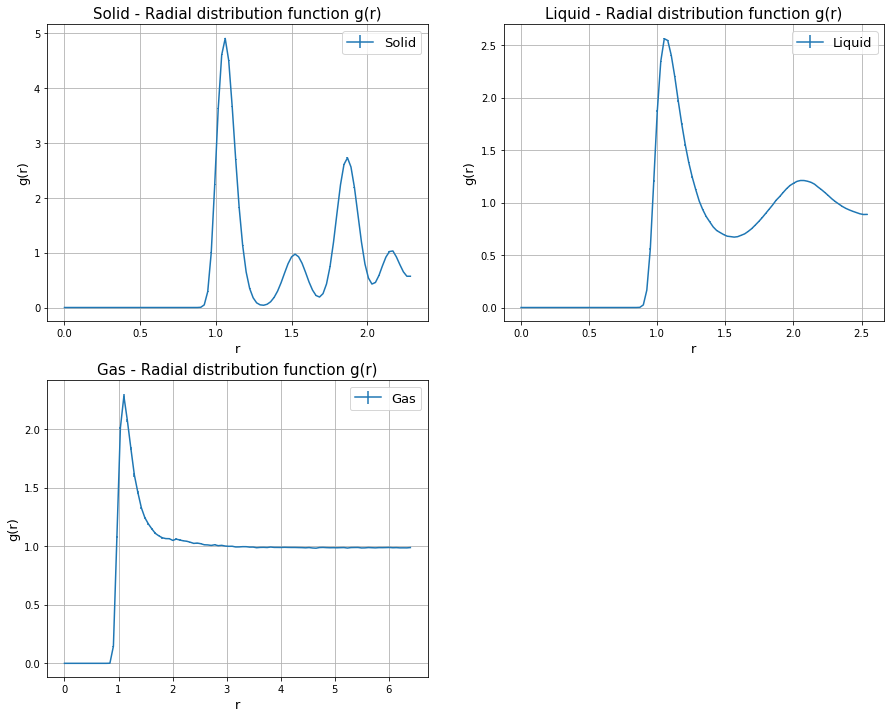

In [24]:
#### g(r) distribution
## final average value (considering all the blocks) as a function of r
#Gave << setw(wd) << iblk <<  setw(wd)  << r << setw(wd)<< glob_av[k+igofr]/(double)iblk << setw(wd) << err_gdir << endl;
phases= ["Solid", "Liquid", "Gas"]
M=100
plt.figure(figsize=(15,12))
i=1
for p, g_vals, g_err, r_vals in (phases, g_values, g_errs, r_values):
    plt.subplot(2,2,i)
    plt.errorbar(r_vals, g_vals, g_err, label = p)
    plt.xlabel("r", size=13)
    plt.ylabel("g(r)", size=13)
    plt.title(p + " - Radial distribution function g(r)", size=15)
    plt.legend(loc="upper right", fontsize=13)
    plt.grid(True)
    i += 1

As expected, in all the three cases *g(r)* is $\approx 0$ till *r* reaches $\approx 1$, due to the Lennard-Jones potential. 

### 7.3 radial distribution function $g(r)$ in the Molecular Dynamics NVE code

$\rightarrow$ NVE_nuovo.cpp

The evaluation of *g(r)* was added to the NVE code from esercise 4 as well. As for the NVT code, the graphs below report the final average values of g(r) for $r \in \left[ 0; L/2\right]$, to show the radial distribution as a function of *r*.

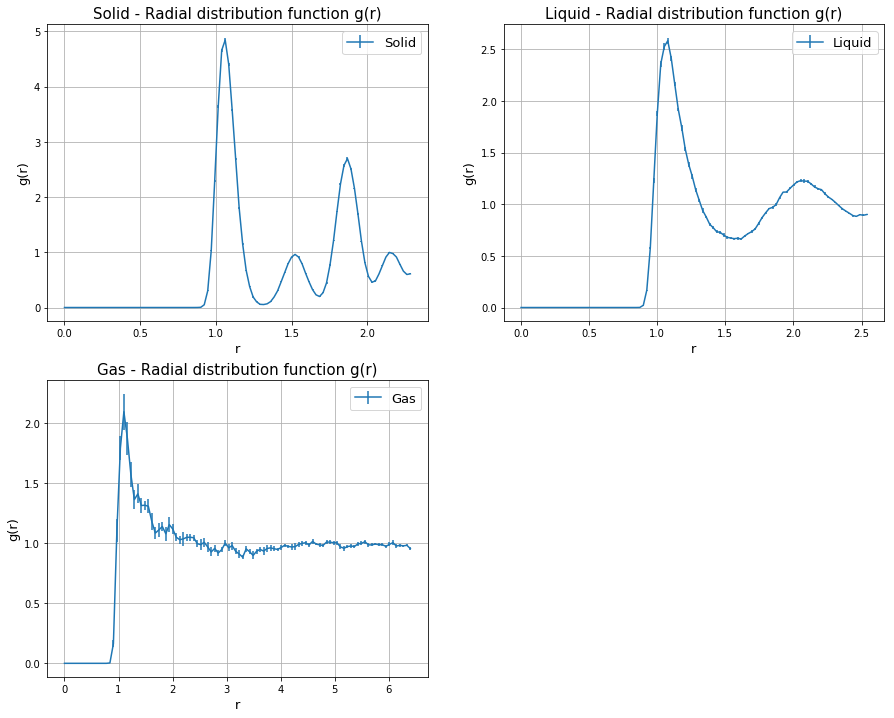

In [28]:
#### g(r) distribution
## final average value (considering all the blocks) as a function of r
#Gave << setw(wd) << iblk <<  setw(wd)  << r << setw(wd)<< glob_av[k+igofr]/(double)iblk << setw(wd) << err_gdir << endl;
phases= ["Solid", "Liquid", "Gas"]
M=100
plt.figure(figsize=(15,12))
i=1
for p in phases:
    g_vals = np.loadtxt("./" +p +"/gave_blocks_NVE4_afterequi.dat", max_rows=M, usecols=4)
    g_err = np.loadtxt("./" +p +"/gave_blocks_NVE4_afterequi.dat", max_rows=M, usecols=5)
    r_vals = np.loadtxt("./" +p +"/gave_blocks_NVE4_afterequi.dat", max_rows=M, usecols=2)
    
    plt.subplot(2,2,i)
    plt.errorbar(r_vals, g_vals, g_err, label = p)
    plt.xlabel("r", size=13)
    plt.ylabel("g(r)", size=13)
    plt.title(p + " - Radial distribution function g(r)", size=15)
    plt.legend(loc="upper right", fontsize=13)
    plt.grid(True)
    i += 1

### 7.4 Argon simuations

**7.4.1** The following graphs report the average values of $\frac{U}{N}$ and $P$ obtained through the data-blocking method with the Monte Carlo NVT simulation. The average value as a function of the number of steps is reported. The system was simulated in the followiong conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$),
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$),
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$).

Results are reported in SI units.

In [24]:
##Parameters to rescale values in SI units:
## SI units
nm = 10**(-9) #[m]
k_B = 1.380649E-23 
amu = 1.66054E-27 #[kg]

##Argon values
sigma = 0.34*nm
epsilon = 120*k_B 
m=39.948*amu

In [28]:
epsilon

1.6567788e-21

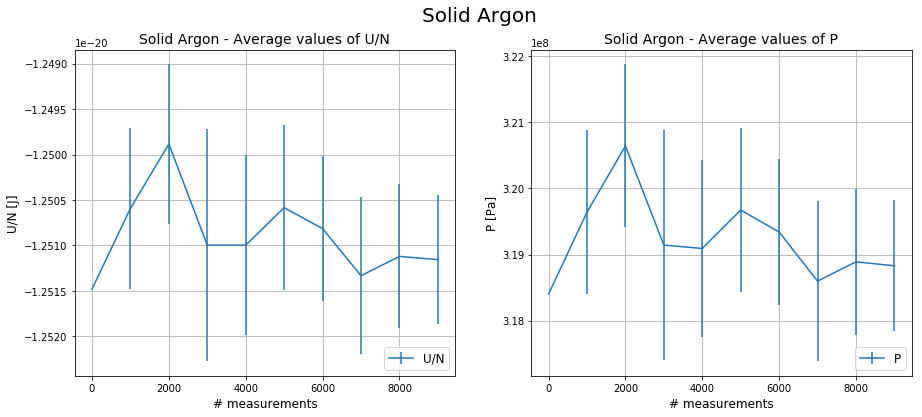

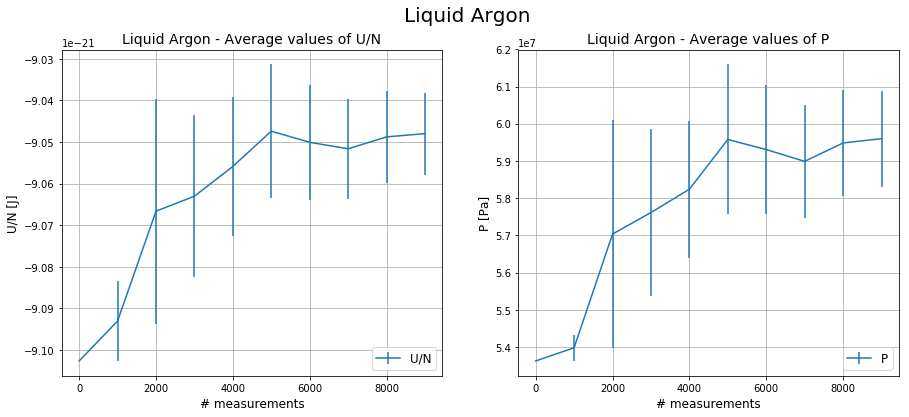

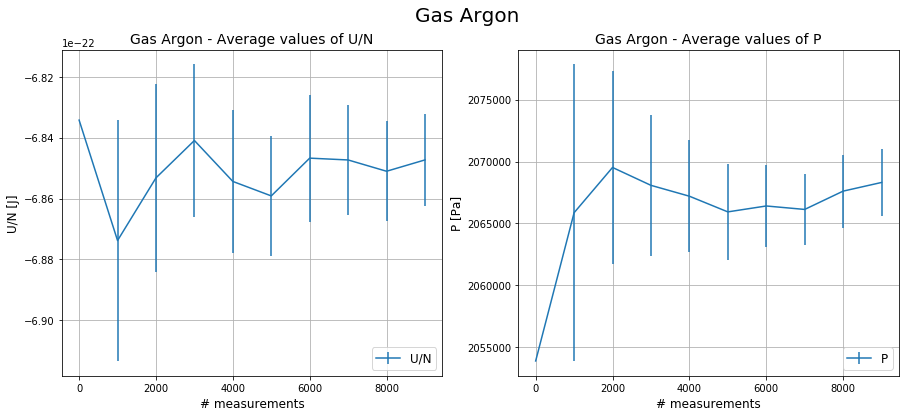

In [5]:
N=100
x = np.arange(N)

names = ["Solid", "Liquid" , "Gas"]
obs = [ "U/N", "P"]

for p in range(3):
    ##Reading
    press_ave = np.loadtxt( './'+names[p]+'/output_press_prova3.dat',max_rows=N, usecols=2)
    err_press = np.loadtxt( './'+names[p]+'/output_press_prova3.dat',max_rows=N, usecols=3)
    epot_ave = np.loadtxt( './'+names[p]+'/output_epot_prova3.dat',max_rows=N, usecols=2)
    err_epot = np.loadtxt( './'+names[p]+'/output_epot_prova3.dat',max_rows=N, usecols=3)
    averages = [ epot_ave, press_ave,]
    err = [err_epot, err_press]

##Rescaling
    for i in range(2):
        if(i==0): ##potential energy per particle
            averages[i] *= epsilon
            err[i] *= epsilon
        else:  ##pressure
            averages[i] *= epsilon/(sigma**3)
            err[i] *= epsilon/(sigma**3)

    ##Plot
    plt.figure(figsize=(15,6))
    plt.suptitle( names[p] + " Argon", size=20)

    for i in range(2):
        plt.subplot(1,2, i+1)
        plt.errorbar(x,averages[i], err[i], label=obs[i])
        if(i==0):
            plt.ylabel( obs[i] + " [J]", size=12)
        else:
            plt.ylabel(obs[i] + " [Pa]", size=12)
        plt.xlabel('# blocks',size=12)   
        plt.title(names[p] + " Argon - Average values of " + obs[i], size=14)
        plt.legend(loc="lower right" , fontsize=12)
        plt.grid(True)

**7.4.2 Molecular Dynamics NVE code vs Monte Carlo NVT code**

The following graphs compare the *g(r)* trend as a function of r evaluted through:
- A - left) the Molecular Dynamics NVE code
- B - right) the Monte Carlo NVT code

All values are the final average value considering all the blocks in the data-blocking method. Results are reported in SI units.

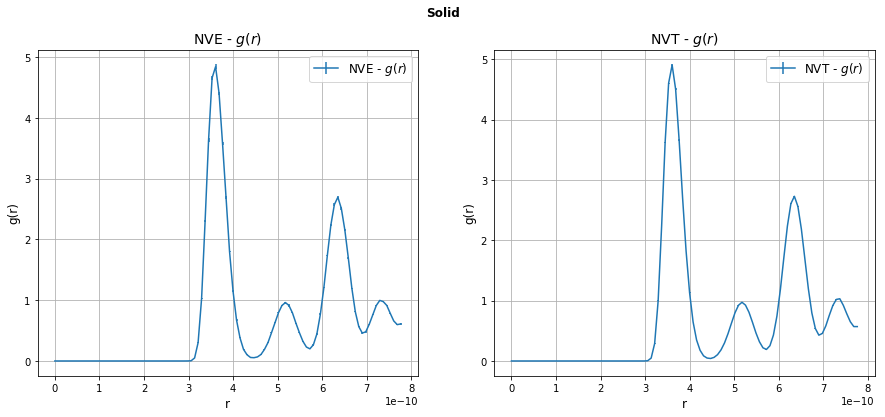

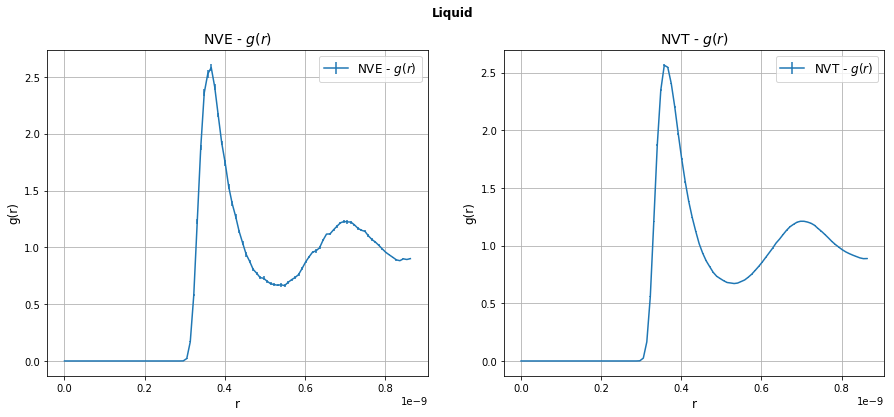

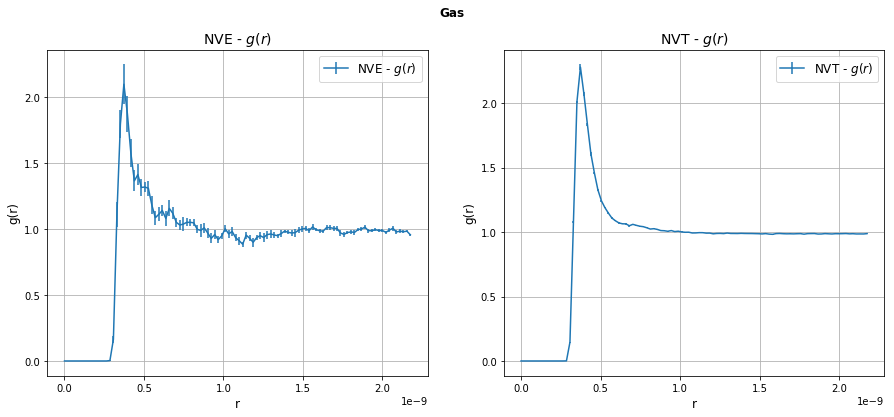

In [45]:
M=100 # #bins
phases = ["Solid", "Liquid" , "Gas"]
obs = [ "NVE - $g(r)$", "NVT - $g(r)$"]

for p in phases:
    ##Reading
    g_valsE = np.loadtxt("./" +p +"/gave_blocks_NVE4_afterequi.dat", max_rows=M, usecols=4)
    g_errE = np.loadtxt("./" +p +"/gave_blocks_NVE4_afterequi.dat", max_rows=M, usecols=5)
    r_valsE = np.loadtxt("./" +p +"/gave_blocks_NVE4_afterequi.dat", max_rows=M, usecols=2)
    g_valsT = np.loadtxt("./" +p +"/output_gaveprova4.dat", max_rows=M, usecols=3)
    g_errT = np.loadtxt("./" +p +"/output_gaveprova4.dat", max_rows=M, usecols=4)
    r_valsT = np.loadtxt("./" +p +"/output_gaveprova4.dat", max_rows=M, usecols=1)
    g_vals = [ g_valsE, g_valsT]
    err = [g_errE, g_errT]
    r_vals = [r_valsE , r_valsT]

##Rescaling
    for r in r_vals:
        r *= sigma

    ##Plot
    plt.figure(figsize=(15,6))
    plt.suptitle( p, weight="bold")

    for i in range(2):
        plt.subplot(1,2, i+1)
        plt.errorbar(r_vals[i],g_vals[i], err[i], label=obs[i])
        plt.ylabel("g(r)", size=12)
        plt.xlabel('r',size=12)   
        plt.title(obs[i] , size=14)
        plt.legend(loc="upper right" , fontsize=12)
        plt.grid(True)

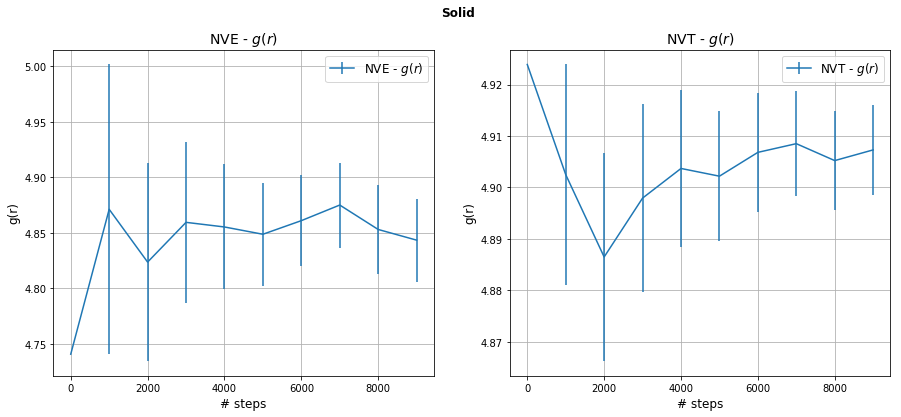

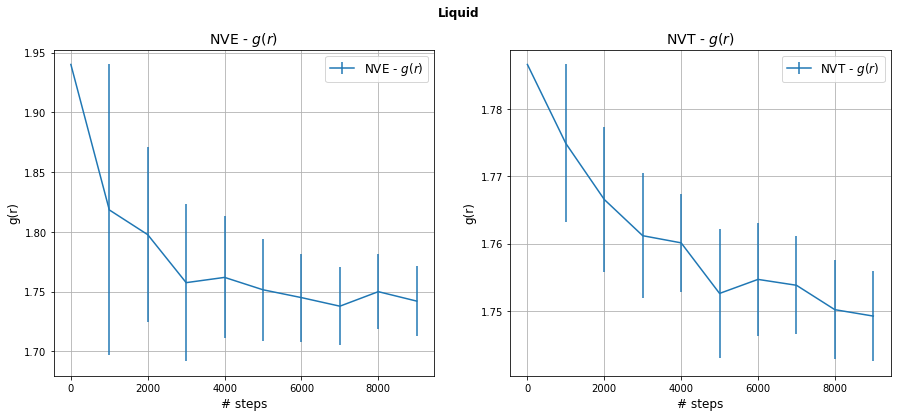

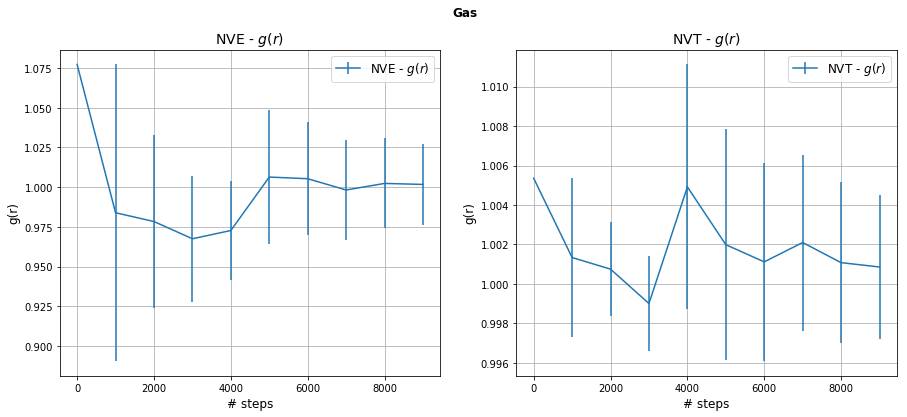

In [52]:
N=10
x = np.arange(N)
x *= 1000 ## 1000 steps in ogni blocco

phases = ["Solid", "Liquid" , "Gas"]
obs = [ "NVE - $g(r)$", "NVT - $g(r)$"]

for p in phases:
    ##Reading
    g_valsE = np.loadtxt("./" +p +"/max_blocks_NVEmax_afterequi.dat", max_rows=N, usecols=4)
    g_errE = np.loadtxt("./" +p +"/max_blocks_NVEmax_afterequi.dat", max_rows=N, usecols=5)
    g_valsT = np.loadtxt("./" +p +"/output_gofrNVTmax.dat", max_rows=N, usecols=2)
    g_errT = np.loadtxt("./" +p +"/output_gofrNVTmax.dat", max_rows=N, usecols=3)
    g_vals = [ g_valsE, g_valsT]
    err = [g_errE, g_errT]

##Rescaling
    for r in r_vals:
        r *= sigma

    ##Plot
    plt.figure(figsize=(15,6))
    plt.suptitle( p, weight="bold")

    for i in range(2):
        plt.subplot(1,2, i+1)
        plt.errorbar(x,g_vals[i], err[i], label=obs[i])
        plt.ylabel("g(r)", size=12)
        plt.xlabel('# steps',size=12)   
        plt.title(obs[i] , size=14)
        plt.legend(loc="upper right" , fontsize=12)
        plt.grid(True)

As expected, the trend is approximately the same.

In [53]:
##############################################################################################

***For the NVE code, run this cells to quickly run the simulation:***

- Equilibration solid: 1000 with both restart and rescale off + $1000$ steps $\times 7$ times with both restart and rescale on (+ 100 blocks of 2000 steps each to measure)
- Equilibration liquid: 1000 with both restart and rescale off + $1000$ steps $\times 5$ times with both restart and rescale on + 10000 steps with both restart and rescale on (+ 100 blocks of 2000 steps each to measure)
- Equilibation gas: 500 with both restart and rescale off + $500$ steps $\times 5$ times with both restart and rescale on + 10000 steps with both restart and rescale on (+ 100 blocks of 2000 steps each to measure)

In [42]:
import os
## solid , liquid , gas
dirnames = ["Solid\n" , "Liquid\n", "Gas\n"]
rho = ["1.1\n", "0.8\n", "0.05\n"]
temp = ["0.8\n", "1.1\n" , "1.2\n"]
r_cut = ["2.2\n", "2.5\n", "5.0\n"]

##Solid:
in_file = open("input_mio.dat", "r")
list_of_lines = in_file.readlines()
list_of_lines[0] = temp[0]
list_of_lines[2] = rho[0]
list_of_lines[3] = r_cut[0]
list_of_lines[11] = dirnames[0]
##first step of the equilibration -> 1000 steps with neither restarting nor rescaling speeds
list_of_lines[5] = "100\n"
list_of_lines[6] = "10\n" ## 1000 steps tot
list_of_lines[10] = "_NVEmax_equilibration\n"
list_of_lines[8] = "0\n"
list_of_lines[9] = "0\n"
in_file.close()

out_file = open("input_mio.dat", "w")
out_file.writelines(list_of_lines)
out_file.close()

os.system("./NVE_nuovo.exe")

0

In [43]:
## equilibration-> run the simulation 5 times restarting and rescaling
in_file = open("input_mio.dat", "r")
list_of_lines = in_file.readlines()
list_of_lines[8] = "1\n"
list_of_lines[9] = "1\n"

out_file = open("input_mio.dat", "w")
out_file.writelines(list_of_lines)
out_file.close()

for i in range(7):
    os.system("./NVE_nuovo.exe")
    print("run", i+1 , "-> finished")

run 1 -> finished
run 2 -> finished
run 3 -> finished
run 4 -> finished
run 5 -> finished
run 6 -> finished
run 7 -> finished


In [ ]:
## remove averages after equilibration
os.system("rm Solid/*blocks*NVE*equilibration*")
os.system("rm Liquid/*blocks*NVE*equilibration*")
os.system("rm Gas/*blocks*NVE*equilibration*")

In [44]:
## per ora metto-> 10 blocchi con 1000 steps in ogni blocco (= 100 misure per blocco)
## after equilibration:
in_file = open("input_mio.dat", "r")
list_of_lines = in_file.readlines()
list_of_lines[8] = "1\n"
list_of_lines[9] = "1\n"
list_of_lines[5] = "1000\n"
list_of_lines[6] = "10\n"
list_of_lines[10] = "_NVEmax_afterequi\n"

out_file = open("input_mio.dat", "w")
out_file.writelines(list_of_lines)
out_file.close()

os.system("./NVE_nuovo.exe")

0